In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
sns.set()

%matplotlib inline

/Users/bensorscher/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from model import Model
from data_manager import DataManager
from hd_cells import HDCells
from place_cells import PlaceCells

In [3]:
def load_checkpoints(sess):
    saver = tf.train.Saver(max_to_keep=2)
    save_dir = "./saved"
    checkpoint_dir = save_dir + "/checkpoints"
    
    checkpoint = tf.train.get_checkpoint_state(checkpoint_dir)
    if checkpoint and checkpoint.model_checkpoint_path:
        saver.restore(sess, checkpoint.model_checkpoint_path)

In [4]:
np.random.seed(1)

sequence_length = 100
data_manager = DataManager()
place_cells = PlaceCells()
hd_cells = HDCells()
data_manager.prepare(place_cells, hd_cells)

model = Model(place_cell_size=place_cells.cell_size,
                          hd_cell_size=hd_cells.cell_size,
                          sequence_length=sequence_length)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Load checkpoints
load_checkpoints(sess)

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

INFO:tensorflow:Restoring parameters from ./saved/checkpoints/checkpoint-35999


In [5]:
def get_trajectory(index, batch_size, condition='train'):

    # get predicted place cells outputs
    out = data_manager.get_confirm_batch(batch_size, sequence_length, index, condition)
    inputs_batch, place_init_batch, hd_init_batch, \
        place_pos_batch, head_dir_batch, place_cells_batch, hd_cells_batch = out
    place_outputs_result, hd_outputs_result = sess.run(
                                                [model.place_outputs_result, 
                                                 model.hd_outputs_result],
                                                feed_dict = {
                                                    model.inputs : inputs_batch,
                                                    model.place_init : place_init_batch,
                                                    model.hd_init : hd_init_batch,
                                                    model.keep_prob : 1.0
                                                })
    # Place cells
    # reshape over batch
    place_cells_batch = np.reshape(place_cells_batch, [-1, place_cells_batch.shape[-1]])
    place_pos_batch = np.reshape(place_pos_batch, [-1, 2])

    # get predicted place cell outputs
    place_cells_predicted = []
    for c in place_outputs_result:
        cell_pos = place_cells.get_nearest_cell_pos(c)
        place_cells_predicted.append(cell_pos)
    place_cells_predicted = np.asarray(place_cells_predicted)

    # get ground truth place cell outputs
    place_cells_gt = []
    for c in place_cells_batch:
        cell_pos = place_cells.get_nearest_cell_pos(c)
        place_cells_gt.append(cell_pos)
    place_cells_gt = np.asarray(place_cells_gt)

    # get ground truth positions
    pos = place_pos_batch
    
    #HD cells
    # reshape over batch
    hd_cells_batch = np.reshape(hd_cells_batch, [-1, hd_cells_batch.shape[-1]])
    head_dir_batch = np.reshape(head_dir_batch, -1)

    # get predicted place cell outputs
    hd_cells_predicted = []
    for hd in hd_outputs_result:
        head_pos = hd_cells.get_nearest_hd(hd)
        hd_cells_predicted.append(head_pos)
    hd_cells_predicted = np.asarray(hd_cells_predicted)

    # get ground truth place cell outputs
    hd_cells_gt = []
    for hd in hd_cells_batch:
        head_pos = hd_cells.get_nearest_hd(hd)
        hd_cells_gt.append(head_pos)
    hd_cells_gt = np.asarray(hd_cells_gt)

    # get ground truth positions
    head_dir = head_dir_batch
    
    return pos, place_cells_gt, place_cells_predicted, head_dir, hd_cells_gt, hd_cells_predicted

## Visualize batch

In [26]:
inputs_batch, place_outputs_batch, hd_outputs_batch, \
            place_init_batch, hd_init_batch, pos_batch, head_dir_batch = data_manager.get_demo_batch(50, 100)
pos_batch = np.reshape(pos_batch, [-1,2])

In [27]:
starting_points = np.zeros([50,2])
for i, c in enumerate(place_init_batch[:,0,:]):
    starting_points[i,:] = place_cells.get_nearest_cell_pos(c)

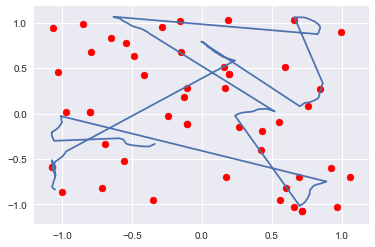

In [28]:
plt.plot(pos_batch[:1000,0], pos_batch[:1000,1])
plt.scatter(starting_points[:,0], starting_points[:,1], c='r')

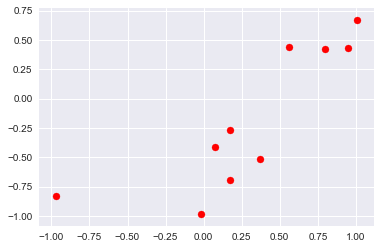

In [26]:
plt.scatter(starting_points[:,0], starting_points[:,1], c='r')

In [21]:
place_init_batch[:,0,:].shape

(10, 256)

(5000, 2)

## Visualize head direction

In [ ]:
# plot
num_plots = 9
index_offset = 0
plt.figure(figsize=(15, 4*num_plots//3))
for i in range(num_plots):
    _,_,_, head_dir, hd_cells_gt, hd_cells_predicted = get_trajectory(i+index_offset, 3)
    plt.subplot(num_plots//3, 3, i+1)
#     plt.plot(head_dir)
    plt.plot(hd_cells_gt)
    plt.plot(hd_cells_predicted)
plt.show()

## Visualize trajectory

In [ ]:
# plot
num_plots = 27
index_offset = 0
plt.figure(figsize=(15, 5*num_plots//3))
for i in range(num_plots):
    pos, place_cells_gt, place_cells_predicted, _, _, _ = get_trajectory(i + index_offset, 1, 'train')
    plt.subplot(num_plots//3, 3, i+1)
    plt.plot(pos[:,0], pos[:,1])
    plt.plot(place_cells_gt[:,0], place_cells_gt[:,1], "o-")
    plt.plot(place_cells_predicted[1:,0], place_cells_predicted[1:,1], "o-")
    plt.ylim(-1.1, 1.1)
    plt.xlim(-1.1, 1.1)
plt.show()

## Visualize grid cells

In [ ]:
batch_size = 10
sequence_length = 100
resolution = 20
maze_extents = 1.1

activations = np.zeros([512, resolution, resolution], dtype=np.float32) # (512, 32, 32)
counts  = np.zeros([resolution, resolution], dtype=np.int32)        # (32, 32)

index_size = data_manager.get_confirm_index_size(batch_size, sequence_length)

for index in range(index_size):
    out = data_manager.get_confirm_batch(batch_size, sequence_length, index)
    inputs_batch, place_init_batch, hd_init_batch, \
        place_pos_batch, head_dir_batch, place_cells_batch, hd_cells_batch = out
            
    place_pos_batch = np.reshape(place_pos_batch, [-1, 2])
    # (1000, 2)
    
    g = sess.run(
            model.g,
            feed_dict = {
                model.inputs : inputs_batch,
                model.place_init : place_init_batch,
                model.hd_init : hd_init_batch
            })
    
        
    for i in range(batch_size * sequence_length):
        pos_x = place_pos_batch[i,0]
        pos_z = place_pos_batch[i,1]
        x = (pos_x + maze_extents) / (maze_extents * 2) * resolution
        z = (pos_z + maze_extents) / (maze_extents * 2) * resolution
        if x >=0 and x < resolution and z >=0 and z < resolution:
            counts[int(x), int(z)] += 1
            activations[:, int(x), int(z)] += np.abs(g[i, :])

for x in range(resolution):
    for y in range(resolution):
        if counts[x, y] > 0:
            activations[:, x, y] /= counts[x, y]


In [ ]:
activations = (activations - np.min(activations)) / (np.max(activations) - np.min(activations))

hidden_size = 512
# hidden_size = 64

plt.figure(figsize=(15, int(30 * hidden_size / 128)))
for i in range(hidden_size):
    plt.subplot(hidden_size//8, 8, 1 + i)
    plt.title('Unit ' + str(i))
    plt.imshow(activations[i,:,:], interpolation="gaussian", cmap="jet")
    plt.axis('off')    
plt.show()

In [ ]:
import scipy
from scipy.signal import correlate2d

In [ ]:
acorrs = np.zeros([hidden_size, 39, 39])
for index in range(hidden_size):
    acorrs[index,:,:] = correlate2d(activations[index], activations[index], boundary='wrap')
    
plt.figure(figsize=(15, int(30 * 2* hidden_size / 128)))
for i in range(hidden_size):
    plt.subplot(2*hidden_size//8, 8, 1 + 2*i)
    plt.title('Unit ' + str(i))
    plt.imshow(activations[i,:,:], interpolation="gaussian", cmap="jet")
    plt.axis('off') 
    plt.subplot(2*hidden_size//8, 8, 2 + 2*i)
    plt.imshow(acorrs[i,:,:], interpolation="gaussian", cmap="jet")
    plt.axis('off')    
plt.show()